<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Convolutional Neural Network (CNN)

###Install dependencies

In [1]:
!pip install scikeras
!pip install bayesian-optimization
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.7 MB/s eta 0:00:00


###Load Libraries

In [7]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Dropout
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization
from keras.callbacks import EarlyStopping
from time import time
import pickle

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

###Define Functions to Facilitate Metrics Evaluation

In [8]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [9]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/main/Cleaned_data/FS_2.csv'
df = read_csv(path)
df.head()

,date,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
0,12/1/10,323,455,3102.61,423.45,844.0,468.0,578.0
1,1/1/11,345,546,3100.45,415.85,799.0,485.0,557.0
2,2/1/11,362,595,3199.41,410.77,718.0,466.0,552.0
3,3/1/11,376,636,3281.67,414.82,614.0,442.0,574.0
4,4/1/11,383,738,3261.65,451.04,619.0,429.0,595.0


In [10]:
df['date']=pd.to_datetime(df['date'])
#del df['date']

In [11]:
df.set_index('date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2010-12-01 to 2021-03-01
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cpo_pri  124 non-null    int64  
 1   cno_pri  124 non-null    int64  
 2   oli_pri  124 non-null    float64
 3   rps_pri  124 non-null    float64
 4   pno_pri  124 non-null    float64
 5   sbo_pri  124 non-null    float64
 6   sfo_pri  124 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 7.8 KB


In [12]:
df.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


<Figure size 1800x720 with 0 Axes>

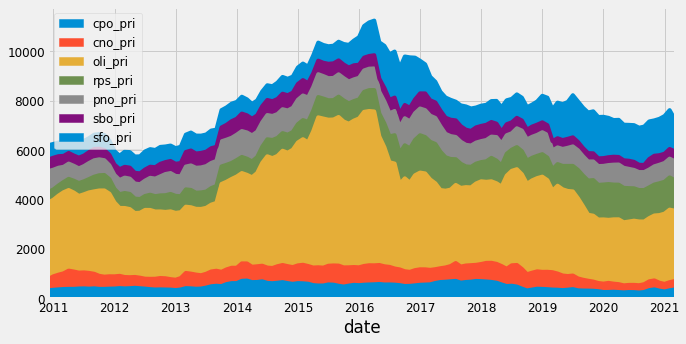

In [13]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('date');
ax.legend(fontsize=12);

##**Convolutional Neural Network Forecasting Technique (CNN)**

###**Split Data into Train Test Segments**

In [14]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 99
Test size: 25


In [15]:
split_date = '2019-02'
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

99 days of training data 
 25 days of testing data 


In [16]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

99 25


In [18]:
print(train.shape)
train.head()

(99, 7)


,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


###Rescaling Training Data

In [19]:
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'oli_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'sfo_pri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,0.112288,0.140918,0.010736,0.528090,0.253193,0.023302
2011-01-01,345,0.305085,0.140327,0.004301,0.443820,0.306536,0.009321
2011-02-01,362,0.408898,0.167408,0.000000,0.292135,0.246917,0.005992
2011-03-01,376,0.495763,0.189919,0.003429,0.097378,0.171609,0.020639
2011-04-01,383,0.711864,0.184440,0.034095,0.106742,0.130817,0.034621


In [20]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

date
2010-12-01    0.0100
2011-01-01    0.0650
2011-02-01    0.1075
2011-03-01    0.1425
2011-04-01    0.1600
Name: cpo_pri, dtype: float64

In [21]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2019-03-01,354,0.637712,0.194855,0.382454,0.381292,-0.039662,0.493342
2019-04-01,348,0.533898,0.264388,0.393951,0.213633,-0.054975,0.597870
2019-05-01,332,0.400424,0.246417,0.453802,0.235262,-0.092159,0.606525
2019-06-01,349,0.317797,0.234308,0.509834,0.320749,-0.074743,0.631824
2019-07-01,372,0.313559,0.223422,0.526454,0.426610,-0.066114,0.773462


In [22]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

date
2019-03-01    0.0875
2019-04-01    0.0725
2019-05-01    0.0325
2019-06-01    0.0750
2019-07-01    0.1325
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [23]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(96, 3, 7) (96,)


In [ ]:
#test_lag = test[1:23]
#len(test) - 1

In [ ]:
#decrement naturally.
#shifted = test.set_index(["date"]).unstack().shift(3).stack()

###CNN Baseline Model Architecture

In [26]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=85, kernel_size=2, activation='tanh', input_shape=(X_test.shape[1], X_test.shape[2])))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(64, activation='tanh'))
cnn_model.add(tf.keras.layers.Dense(1))

# compile model using adam
cnn_model.compile(optimizer='adam',loss='mse',metrics=['mse'])
# model training
history = cnn_model.fit(X_train, y_train, epochs=100, batch_size = 64, validation_split=0.2) #epochs = 30, batch_size = 60

# model evaluation
cnn_model.evaluate(X_test, y_test)

Epoch 1/100
2/2 [==============================] - 1s 164ms/step - loss: 0.1939 - mse: 0.1939 - val_loss: 0.0630 - val_mse: 0.0630
Epoch 2/100
2/2 [==============================] - 0s 31ms/step - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0694 - val_mse: 0.0694
Epoch 3/100
2/2 [==============================] - 0s 31ms/step - loss: 0.0444 - mse: 0.0444 - val_loss: 0.1086 - val_mse: 0.1086
Epoch 4/100
2/2 [==============================] - 0s 30ms/step - loss: 0.0792 - mse: 0.0792 - val_loss: 0.0854 - val_mse: 0.0854
Epoch 5/100
2/2 [==============================] - 0s 30ms/step - loss: 0.0565 - mse: 0.0565 - val_loss: 0.0452 - val_mse: 0.0452
Epoch 6/100
2/2 [==============================] - 0s 29ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0301 - val_mse: 0.0301
Epoch 7/100
2/2 [==============================] - 0s 29ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0357 - val_mse: 0.0357
Epoch 8/100
2/2 [==============================] - 0s 28ms/step - loss: 0.0213 - mse: 0.0

[0.019204679876565933, 0.019204679876565933]

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


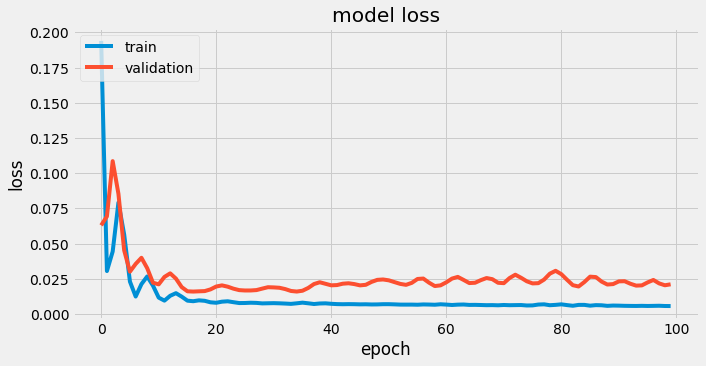

In [27]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [28]:
mse_cnn = cnn_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 27ms/step - loss: 0.0192 - mse: 0.0192


####Baseline MSE = 0.0192

In [29]:
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 2, 85)             1275      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 85)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 85)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                5504      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,844
Trainable params: 6,844
Non-trainable params: 0
____________________________________________________

###Predict the Test without Hyperparameter Tuning

In [30]:
y_pred = cnn_model.predict(X_test)
y_pred

1/1 [==============================] - 0s 87ms/step


array([[ 0.09915901],
       [ 0.06474859],
       [ 0.10742812],
       [ 0.11503207],
       [ 0.06183707],
       [ 0.05928043],
       [ 0.07553317],
       [ 0.06122551],
       [ 0.01604473],
       [-0.02328485],
       [-0.00617843],
       [-0.01386675],
       [-0.03029656],
       [-0.02233214],
       [-0.01146808],
       [-0.04471519],
       [-0.06055314],
       [ 0.03745111],
       [ 0.13719746],
       [ 0.15733457],
       [ 0.07945555],
       [ 0.07220703]], dtype=float32)

In [31]:
y_pred.reshape(1,-1)

array([[ 0.09915901,  0.06474859,  0.10742812,  0.11503207,  0.06183707,
         0.05928043,  0.07553317,  0.06122551,  0.01604473, -0.02328485,
        -0.00617843, -0.01386675, -0.03029656, -0.02233214, -0.01146808,
        -0.04471519, -0.06055314,  0.03745111,  0.13719746,  0.15733457,
         0.07945555,  0.07220703]], dtype=float32)

###Invert Transformed Data

In [32]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[358.6636  344.89944 361.97125 365.01285 343.73483 342.71216 349.21326
  343.4902  325.4179  309.68607 316.52863 313.4533  306.88138 310.06714
  314.41275 301.11392 294.77875 333.98044 373.87897 381.93384 350.78223
  347.8828 ]]


###Plot History, Actual and Predicted Value

In [33]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [34]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [35]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([358.6636 , 344.89944, 361.97125, 365.01285, 343.73483, 342.71216,
       349.21326, 343.4902 , 325.4179 , 309.68607, 316.52863, 313.4533 ,
       306.88138, 310.06714, 314.41275, 301.11392, 294.77875, 333.98044,
       373.87897, 381.93384, 350.78223, 347.8828 ], dtype=float32)

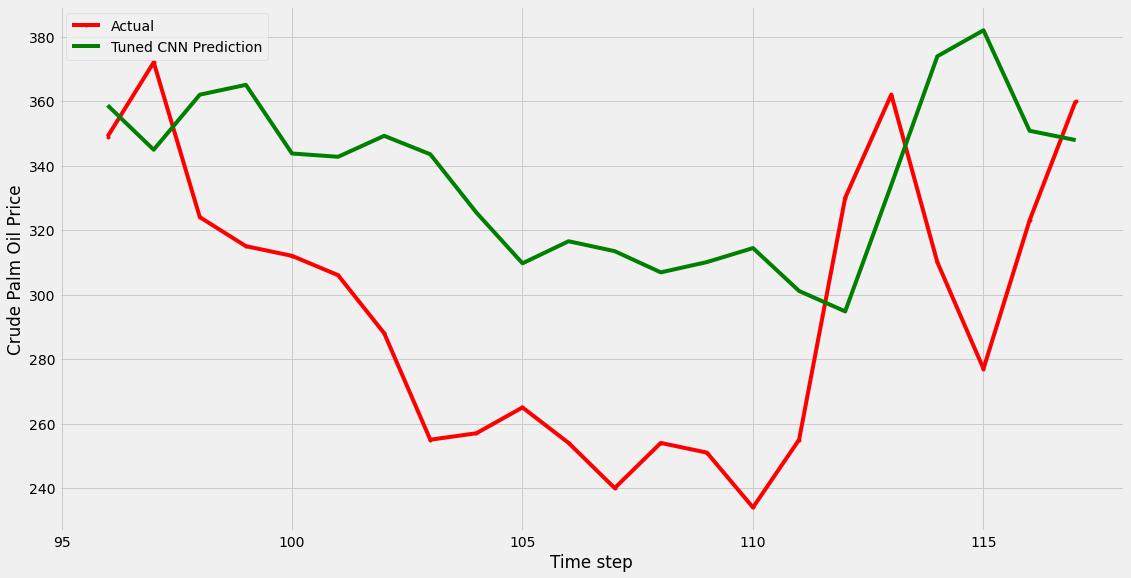

In [37]:
plt.figure(figsize=(17,9))
#plt.grid()
#plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='red', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='green', label="Tuned CNN Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
ax.grid()
plt.savefig('graph_CNN.png')

###Evaluate CNN Model Accuracy

In [38]:
MAE_cnn = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the CNN Model is:', MAE_cnn)

MDA_cnn = mda(y_test_inv, y_pred_inv)
print('MDA value of the CNN Model is:', MDA_cnn)

MAPE_cnn = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the CNN Model is:', MAPE_cnn)

RMSE_cnn = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the CNN Model is:', RMSE_cnn)

MSE_cnn = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the CNN Model is:', MSE_cnn)

MAE value of the CNN Model is: 50.10967462713068
MDA value of the CNN Model is: 0.23809523809523808
MAPE value of the CNN Model is: 18.188775024877124
RMSE value of the CNN Model is: 55.432380747793395
MSE value of the CNN Model is: 3072.748835368336


###Tuning CNN with Keras Tuner

Define A Model-Building Class

In [39]:
#class ANNhypermodel(HyperModel):
class CNNHyperModel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape= input_shape
        
    def build(self, hp):
        model= keras.Sequential()
        # Tune the number of units in the first Dense layer
        # Defining dense units as a close approx to the original neural network to perform a fair comparision!
        hp_units_1= hp.Int('units_1', min_value=64, max_value= 256, step=8)
        hp_units_2= hp.Int('units_2', min_value=32, max_value= 128, step=8)
        #hp_units_3= hp.Int('units_3', min_value=32, max_value= 64, step=16)
        #hp_units_4= hp.Int('units_4', min_value=16, max_value= 32, step=8)

        model.add(keras.layers.Dense(units=hp_units_1, input_shape= self.input_shape))
        model.add(keras.layers.Dense(units=hp_units_2))
        #model.add(keras.layers.Dense(units=hp_units_3, activation='tanh'))
        #model.add(keras.layers.Dense(units=hp_units_4, activation='tanh'))
        model.add(keras.layers.Dense(1))
        #Tune the dropout
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )
        
        # Tune the epoch for the optimizer

        #batch_size = hp.Int('batch_size',8,16,24,32,40,48,56,64,72,80,88,96, step=8)
        
        optimizers = hp.Choice('optimizer',values=['rmsprop','adam', 'AdamW', 'nadam','sgd','adadelta','adagrad'])

        hp_dense_activation = hp.Choice('activation',values=['relu', 'tanh', 'sigmoid', 'linear', 'Softmax', 'ELU', 'linear'])

        # Tune the batch size for the optimizer 
        hp_batch_size = hp.Int('batch_size', min_value = 8, max_value = 96, step = 8, default=8)
        
        # Tune the epoch for the optimizer
        hp_epoch = hp.Int('epoch', min_value = 5, max_value = 100, step = 5, default=5)

        # Tune the epoch for the momentum
        hp_momentum = hp.Float('momentum', min_value = 0.8, max_value = 0.99, step = 0.01, default=0.9)

        # Tune the epoch for the decay
        hp_decay = hp.Float('decay', min_value = 1e-9, max_value = 1e-3, step= 0.0001, default=1e-7)

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default= 0.0005)
       # -------------------------------------------------------
        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mae','mse']
                     )

        return model

#hypermodel= ANNhypermodel(input_shape = (X_test.shape[1], X_test.shape[2]))
hypermodel = CNNHyperModel(input_shape = (X_test.shape[1], X_test.shape[2]))

###Build Random Search Tuner

In [40]:
tuner_rs = RandomSearch(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True
        )

###Run Random Search

In [41]:
tuner_rs.search(X_train, y_train, epochs=16, validation_split=0.2, verbose=0)

###Evaluate Random Search

In [42]:
best_model = tuner_rs.get_best_models(num_models=1)[0]
mse_rs = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 440ms/step - loss: 0.1093 - mae: 0.3130 - mse: 0.1093


####Random Search MSE = 0.1093

In [43]:
best_params = tuner_rs.get_best_hyperparameters()

best_params[0].values

{'units_1': 144,
 'units_2': 80,
 'dropout': 0.2,
 'optimizer': 'sgd',
 'activation': 'Softmax',
 'batch_size': 8,
 'epoch': 20,
 'momentum': 0.8,
 'decay': 0.000700001,
 'learning_rate': 0.001083033272419774}

###Build HYPERBAND optimization

In [44]:
MAX_TRIALS = 20
tuner= RandomSearch(hypermodel,
               objective= 'val_mse',
               max_trials= MAX_TRIALS,
               executions_per_trial= 2,
               directory= 'random_search',
               project_name='randomsearch',
               overwrite=True)

In [46]:
HYPERBAND_MAX_EPOCHS = 150
EXECUTION_PER_TRIAL = 2

tuner= Hyperband(hypermodel,
                   objective= 'val_mse',
                   max_epochs=HYPERBAND_MAX_EPOCHS, #Set 100+ for good results
                   executions_per_trial=EXECUTION_PER_TRIAL,
                   directory= 'hyperband',
                   project_name='hyper',
                   overwrite=True)

# tuner.search_space_summary()

In [47]:
print('searching for the best params!')

t0 = time()
tuner.search(x= X_train,
             y= y_train,
             epochs=100,
             batch_size= 64,
             validation_data= (X_test, y_test),
             verbose=0,
             callbacks= []
            )
print(time()- t0," secs")

# Retreive the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

searching for the best params!


1496.0122952461243  secs


In [48]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units_1')},
second layer is {best_hps.get('units_2')} 
drop out is {best_hps.get('dropout')}
batch_size is {best_hps.get('batch_size')}
epoch is {best_hps.get('epoch')}
optimizer is {best_hps.get('optimizer')}
activation is {best_hps.get('activation')}

momentum is {best_hps.get('momentum')}
decay is {best_hps.get('decay')}

#learning rate is {best_hps.get('learning_rate')}                                        

and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Evaluate the best model.
print(best_model.metrics_names)
loss, mae, mse = best_model.evaluate(X_test, y_test)
print(f'loss:{loss} mae: {mae} mse: {mse}')


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 80,
second layer is 48 
drop out is 0.1
batch_size is 8
epoch is 40
optimizer is adam
activation is tanh

momentum is 0.8
decay is 0.000500001

#learning rate is 0.00010295925479564696                                        

and the optimal learning rate for the optimizer
is 0.00010295925479564696.

[]
1/1 [==============================] - 0s 350ms/step - loss: 0.0120 - mae: 0.0959 - mse: 0.0120
loss:0.012014300562441349 mae: 0.09594318270683289 mse: 0.012014300562441349


In [49]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)

{'units_1': 80, 'units_2': 48, 'dropout': 0.1, 'optimizer': 'adam', 'activation': 'tanh', 'batch_size': 8, 'epoch': 40, 'momentum': 0.8, 'decay': 0.000500001, 'learning_rate': 0.00010295925479564696, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0210'}


###Apply the trained parameters to the CNN

In [120]:
TUcnn_model = tf.keras.Sequential()
TUcnn_model.add(tf.keras.layers.Conv1D(filters=80, kernel_size=2, activation='tanh', input_shape=(X_test.shape[1], X_test.shape[2])))
TUcnn_model.add(tf.keras.layers.Dense(48, activation='tanh'))
#TUcnn_model.add(layers.Dropout(0.1))
TUcnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
TUcnn_model.add(tf.keras.layers.Flatten())
TUcnn_model.add(tf.keras.layers.Dense(1))

In [121]:
TUcnn_model.compile(loss = 'mse', optimizer= keras.optimizers.legacy.Adam(lr=0.00010295, decay = 0.00050), metrics= ['mae', 'mse'])
history = TUcnn_model.fit(X_train, y_train, epochs=40, batch_size=8,validation_split=0.2,shuffle=False) # 80/160

Epoch 1/40


10/10 [==============================] - 1s 32ms/step - loss: 0.0474 - mae: 0.1554 - mse: 0.0474 - val_loss: 0.1102 - val_mae: 0.3008 - val_mse: 0.1102
Epoch 2/40
10/10 [==============================] - 0s 8ms/step - loss: 0.0355 - mae: 0.1405 - mse: 0.0355 - val_loss: 0.1061 - val_mae: 0.2907 - val_mse: 0.1061
Epoch 3/40
10/10 [==============================] - 0s 10ms/step - loss: 0.0320 - mae: 0.1390 - mse: 0.0320 - val_loss: 0.1039 - val_mae: 0.2831 - val_mse: 0.1039
Epoch 4/40
10/10 [==============================] - 0s 8ms/step - loss: 0.0301 - mae: 0.1362 - mse: 0.0301 - val_loss: 0.0999 - val_mae: 0.2773 - val_mse: 0.0999
Epoch 5/40
10/10 [==============================] - 0s 10ms/step - loss: 0.0284 - mae: 0.1319 - mse: 0.0284 - val_loss: 0.0955 - val_mae: 0.2721 - val_mse: 0.0955
Epoch 6/40
10/10 [==============================] - 0s 9ms/step - loss: 0.0270 - mae: 0.1281 - mse: 0.0270 - val_loss: 0.0914 - val_mae: 0.2668 - val_mse: 0.0914
Epoch 7/40
10/10 [==================

Plot Model Loss

<Figure size 720x360 with 0 Axes>

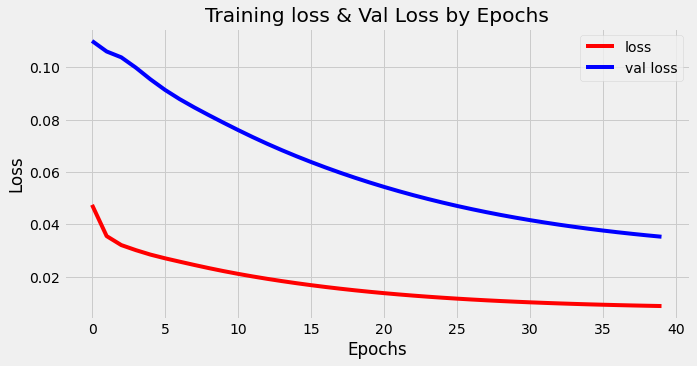

<Figure size 720x360 with 0 Axes>

In [122]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(loss)) 


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r',label='loss')
plt.plot(epochs,val_loss,'blue',label='val loss')
plt.title('Training loss & Val Loss by Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.figure()

In [123]:
y_predTU = TUcnn_model.predict(X_test)
y_predTU

1/1 [==============================] - 0s 113ms/step


array([[ 0.18059365],
       [ 0.14198844],
       [ 0.16179511],
       [ 0.14135092],
       [ 0.11376096],
       [ 0.10112787],
       [ 0.10334109],
       [ 0.09881464],
       [ 0.04872052],
       [ 0.02736631],
       [ 0.03831404],
       [ 0.0346653 ],
       [ 0.01681277],
       [-0.01739877],
       [-0.01312889],
       [-0.04841103],
       [-0.07393553],
       [-0.02342767],
       [ 0.11950532],
       [ 0.15553656],
       [ 0.10381223],
       [ 0.06172872]], dtype=float32)

In [124]:
y_predTU.reshape(1,-1)

array([[ 0.18059365,  0.14198844,  0.16179511,  0.14135092,  0.11376096,
         0.10112787,  0.10334109,  0.09881464,  0.04872052,  0.02736631,
         0.03831404,  0.0346653 ,  0.01681277, -0.01739877, -0.01312889,
        -0.04841103, -0.07393553, -0.02342767,  0.11950532,  0.15553656,
         0.10381223,  0.06172872]], dtype=float32)

###Invert Transformed Tuned Data

In [125]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_predTU.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[391.2375  375.79538 383.71805 375.54037 364.5044  359.45114 360.33646
  358.52585 338.48822 329.94653 334.32562 332.86612 325.7251  312.0405
  313.74844 299.6356  289.42578 309.62894 366.80212 381.21463 360.5249
  343.6915 ]]


In [126]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [127]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [128]:
TU_CNN_Pred = y_pred_inv.flatten()   #y_pred_inv = TU_CNN_Pred
TU_CNN_Pred

array([391.2375 , 375.79538, 383.71805, 375.54037, 364.5044 , 359.45114,
       360.33646, 358.52585, 338.48822, 329.94653, 334.32562, 332.86612,
       325.7251 , 312.0405 , 313.74844, 299.6356 , 289.42578, 309.62894,
       366.80212, 381.21463, 360.5249 , 343.6915 ], dtype=float32)

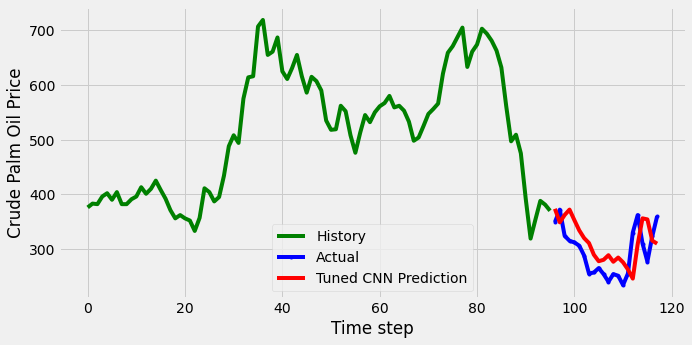

<Figure size 720x360 with 0 Axes>

In [119]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), TU_CNN_Pred, color='red', label="Tuned CNN Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
plt.show();
plt.savefig('CNNOpt.png')

In [117]:
TUMAE_cnn = mean_absolute_error(y_test_inv, TU_CNN_Pred)
print('MAE value of the CNN Model is:', TUMAE_cnn)

TUMDA_cnn = mda(y_test_inv, TU_CNN_Pred)
print('MDA value of the tuned CNN Model is:', TUMDA_cnn)

TUMAPE_cnn = mean_absolute_percentage_error(y_test_inv, TU_CNN_Pred)
print('MAPE value of the tuned CNN Model is:', TUMAPE_cnn)

TURMSE_cnn = mean_squared_error(y_test_inv,TU_CNN_Pred, squared=False)
print('RMSE value of the tuned CNN Model is:', TURMSE_cnn)

TUMSE_cnn = mean_squared_error(y_test_inv,TU_CNN_Pred)
print('MSE value of the tuned CNN Model is:', TUMSE_cnn)

MAE value of the CNN Model is: 38.3348423350941
MDA value of the tuned CNN Model is: 0.3333333333333333
MAPE value of the tuned CNN Model is: 13.117530443685885
RMSE value of the tuned CNN Model is: 43.01671720661321
MSE value of the tuned CNN Model is: 1850.4379592337327


Comparing tuned CNN Actual VS Predicted (Zoomed-IN)

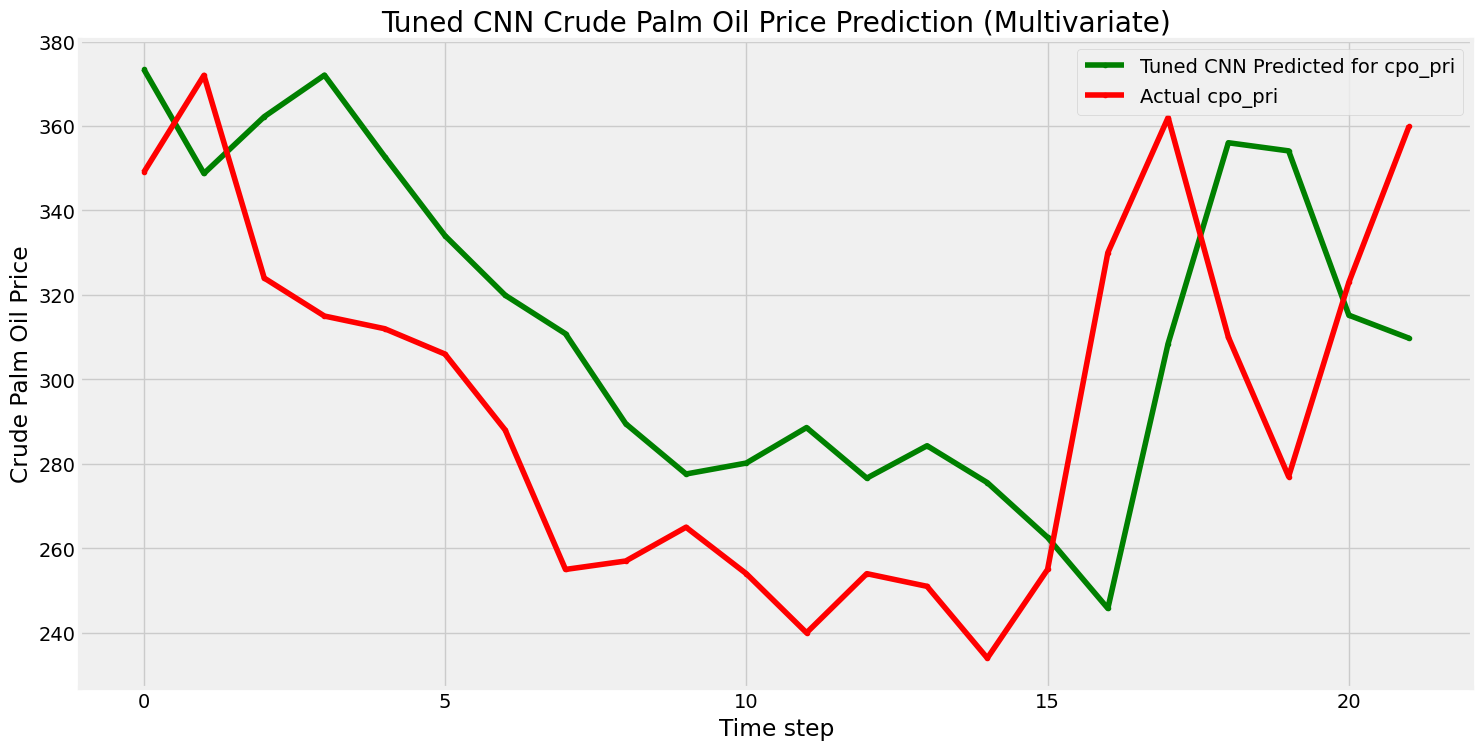

<Figure size 720x360 with 0 Axes>

In [118]:
#Plot the graph between actual vs predicted values
#plt.figure(figsize=(15,7))  #(10,6))
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(TU_CNN_Pred, color= 'green',marker='.',label = 'Tuned CNN Predicted for cpo_pri')
plt.plot(y_test_inv, color = 'red',marker='.',label = 'Actual cpo_pri ')
plt.title("Tuned CNN Crude Palm Oil Price Prediction (Multivariate)")
plt.xlabel("Time step")
plt.ylabel("Crude Palm Oil Price")
plt.legend()
plt.show()
plt.savefig('graph_TUcnn.png')

##Results

Baseline MSE         = 0.0192

Random search MSE    = 0.1093

Hyperband search MSE = 0.0120

Baseline (CNN) RSME  = 55.43

Tuned CNN RSME       = 43.01

The tuned CNN is superior to the basseline based on the RSME result

In [ ]:
TU_CNN_Pred

array([347.44516, 340.68094, 350.3727 , 349.47916, 338.25525, 325.55246,
       326.9378 , 325.72952, 309.97247, 299.66055, 303.72882, 307.1458 ,
       296.03058, 283.43015, 286.5078 , 285.74634, 274.33182, 275.08328,
       328.6628 , 367.21143, 348.66684, 324.47903], dtype=float32)

In [ ]:
dfCNN = pd.DataFrame(TU_CNN_Pred)

print(df)

             0
0   346.603302
1   332.371765
2   343.059052
3   332.408813
4   313.587738
5   302.663574
6   311.632263
7   308.595581
8   290.542999
9   270.774170
10  276.457581
11  270.931183
12  260.275299
13  256.084198
14  268.680023
15  265.947815
16  252.900360
17  300.554657
18  370.926758
19  371.802551
20  343.249298
21  327.434967
